# Content Moderation and Toxicity Classification using Naive Bayes and SGD

This notebook focuses on implementing a feature-level combination of Naive Bayes and SVM for classifying toxic comments in the **Jigsaw Toxic Comment Classification Dataset**.

**Naive Bayes:** It is a probabilistic classifier that learns the likelihood of each object, its features, and the groups to which it belongs. It is known for its simplicity and effectiveness.

**Stochastic Gradient Descent:** It is an optimization technique used in machine learning algorithms, primarily for training linear classifiers and neural networks. It updates the model incrementally, m
aking it well-suited for large datasets.





**1. Imports**

In [2]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import inflect
import re
import string
!pip install contractions
import contractions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.0 MB/s eta 0:00:00


# Preparing Data

**1. Loading dataset**

We begin by loading the dataset. This dataset will then be used for training and testing. It includes user-generated comments with labels indicating various types of toxicity.


In [3]:
data = pd.read_csv('/content/drive/MyDrive/ML Proj/Dataset/Train/train.csv')

data = data.drop(columns = ['id'])

data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**2. Analyzing the dataset**


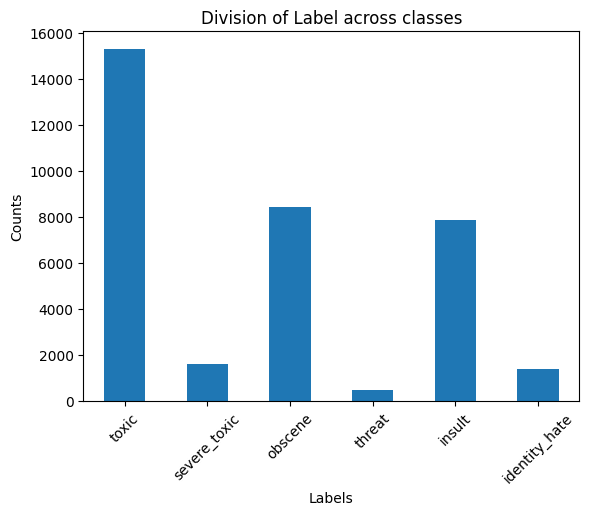

In [4]:
label_count = data.iloc[:,1:].sum()

label_count.plot(kind='bar')
plt.title('Division of Label across classes')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

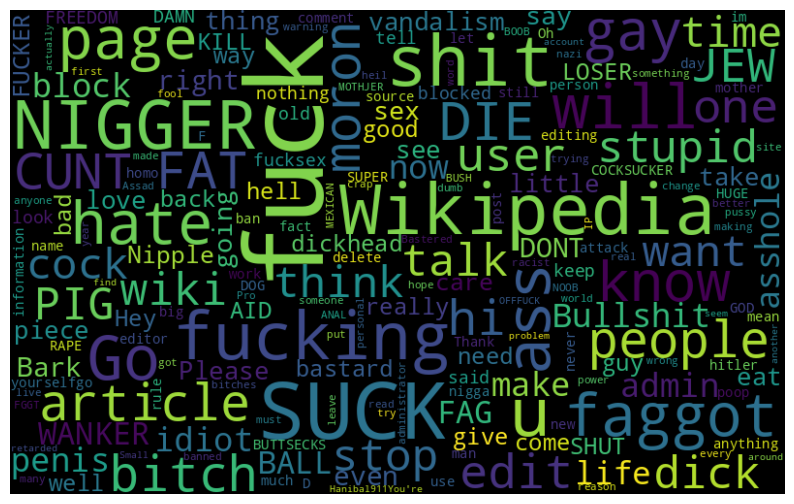

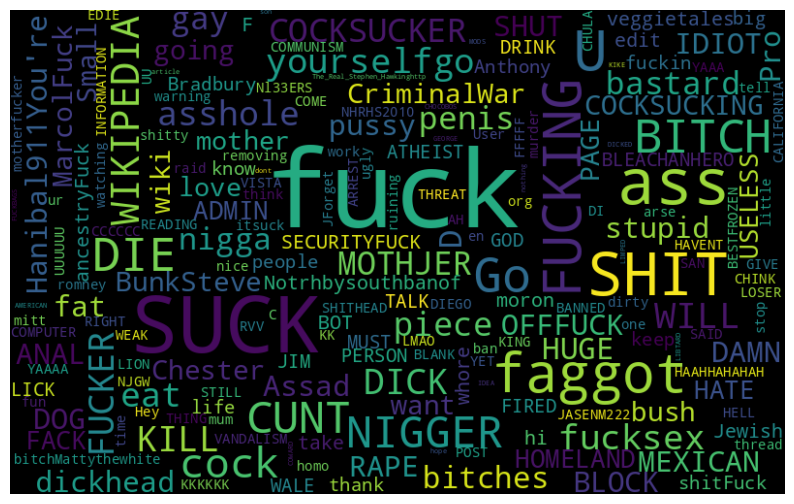

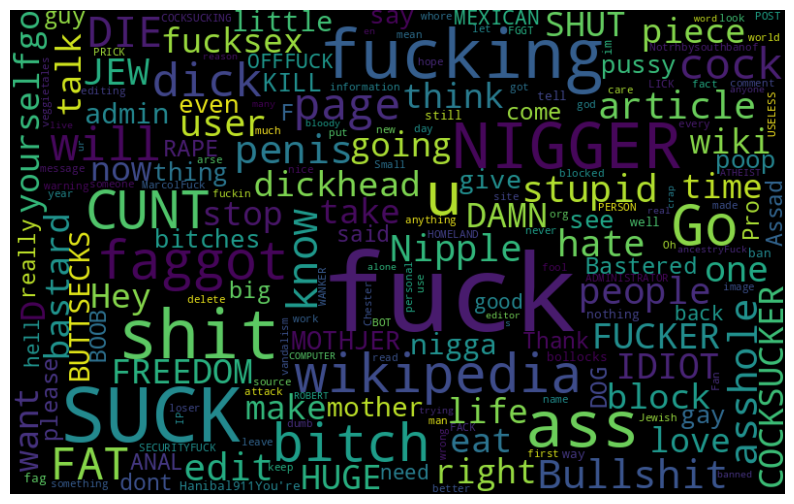

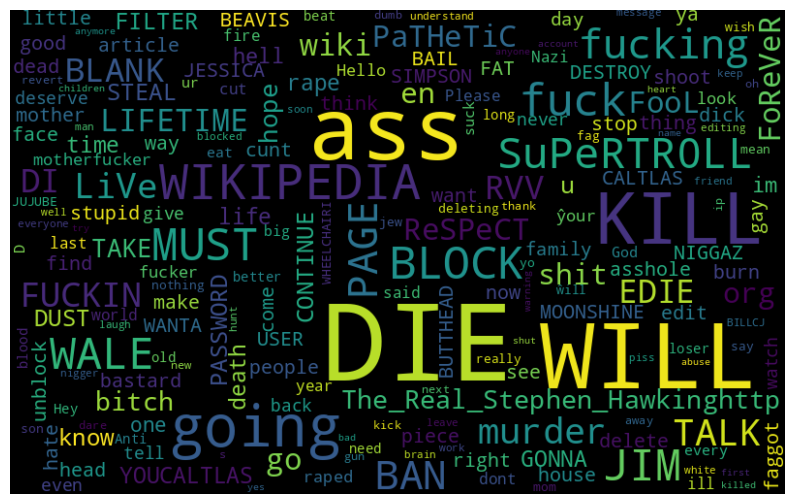

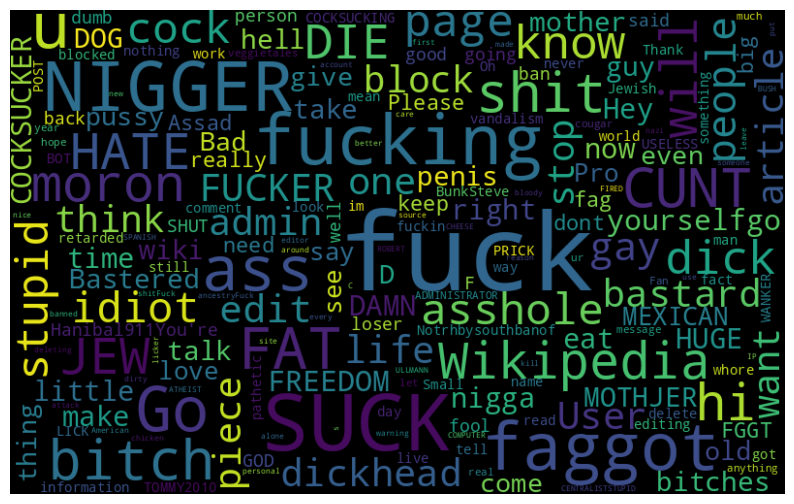

In [5]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

toxic_comments = data[data['toxic'] == 1]
severe_toxic_comments = data[data['severe_toxic'] == 1]
obscene_comments = data[data['obscene'] == 1]
threat_comments = data[data['threat'] == 1]
insult_comments = data[data['insult'] == 1]

def create_wordcloud(comments):
    all_words = ' '.join([text for text in comments])
    wordcloud = WordCloud(width=800, height=500,
                          max_font_size=110,
                          collocations=False).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

create_wordcloud(toxic_comments['comment_text'])
create_wordcloud(severe_toxic_comments['comment_text'])
create_wordcloud(obscene_comments['comment_text'])
create_wordcloud(threat_comments['comment_text'])
create_wordcloud(insult_comments['comment_text'])

**3. Test-train Split**


In [6]:
data_comp = np.asarray(data.iloc[:,0])
labels_comp = np.asarray(data.iloc[:,1:])

X_train, X_test, y_train, y_test = train_test_split(data_comp, labels_comp, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (127656,)
Training labels shape: (127656, 6)
Test data shape: (31915,)
Test labels shape: (31915, 6)


**4. Pre-processing of comments**

This function preprocess the text data from the Jigsaw Toxic Comment Classification Dataset.


*   **Lowercasing:** Converts all characters in the comment to lowercase, to mantain consistency
*   **Removing Non-ASCII characters:** Removes non-ASCII characters to simplify text, and focus on English language words
*   **Expanding Contractions:** Replaces contraction like "can't" to "can not" for clarity and to mantain consistency
*   **Removing URLs:** Removes URLs starting with 'https', 'www'
*   **Removing Punctuations:** Remove punctuation marks from the comments as mostly they are irrelevant for the classifcation problem
*   **Removing Numbers:** Removes numbers as they aren't relevant in this classification problem
*   **Removing Stop Words:** Filters out stop words like "is", "the" and etc. These words occur frequently and offer little value for analysis

By performing these pre-processing steps, we create a cleaner and more standardized dataset that can help improve the performance of our classification models. Each step is aimed at reducing the complexity of the text data, which can lead to more efficient and effective learning by the models we use. This pre-processed data should help the model to focus on the textual patterns most relevant to identifying different forms of toxicity in online comments.






In [7]:
stop_words = set(stopwords.words('english'))

def pre_process_comments(data):
    processed_data = []

    # for idx in tqdm(range(len(data))):
    for idx in range(len(data)):
        comment = data[idx]
        # converting to lowercase
        comment = comment.lower()

        # removing non-ascii characters
        comment = comment.encode('ascii', 'ignore').decode('ascii')

        # expanding contractions
        comment = contractions.fix(comment)

        # removing URLs
        comment = re.sub(r'http\S+|www\S+|https\S+', '', comment)

        # removing mentions
        comment = re.sub(r'<[^>]+>', '', comment)

        # removing punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))

        # removing numbers
        comment = re.sub(r'\d+', '', comment)

        # tokenizing the words
        tokens = comment.split()

        # removing stop words and numbers
        tokens = [word for word in tokens if word not in stop_words]

        comment = ' '.join(tokens)

        processed_data.append(comment)

    return processed_data

In [8]:
X_train = pre_process_comments(X_train)
X_test = pre_process_comments(X_test)

In [9]:
print(X_train[5])

archive february november wikipedia signpost february read signpost full singlepage unsubscribe wikipedia signpost february read signpost full singlepage unsubscribe wikipedia signpost march read signpost full singlepage unsubscribe wikipedia signpost march read signpost full singlepage unsubscribe wikipedia signpost march read signpost full singlepage unsubscribe wikipedia signpost march read signpost full singlepage unsubscribe wikipedia signpost march


# Feature Extraction using Bag-of-Words Model

We are using CountVectorizer to convert our text data into Bag-of-words model. Essentialy, it converts collection of text documents into a matrix of token counts.

The Bag-of-Words (BoW) model provides a foundational representation of the text data, capturing the presence and frequency of words within the documents. BoW features are high-dimensional, sparse, and they offer a basic but powerful way to represent text for machine learning models.

In [10]:
'''
min_df = 3 to ignore words that appear in less than 3 documents
max_df = 0.9 to ignore words that appear in more than 90% of documents
'''
vectorizer = CountVectorizer(min_df = 3, max_df = 0.9)

# Fit and transform train and test sets
train_bow = vectorizer.fit_transform(X_train)
test_bow = vectorizer.transform(X_test)

# Training Naive Bayes Classifiers for Multi-Label Classification

We utilize Naive Bayes for its proficiency in initial feature extraction, converting raw text into a format that captures the underlying likelihoods of toxic versus non-toxic comments.

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier

# Create a Multinomial Naive Bayes classifier
nb_classifier = MultiOutputClassifier(MultinomialNB())

# Train the classifier on training data
nb_classifier.fit(train_bow, y_train)

MultiOutputClassifier(estimator=MultinomialNB())

# Generating Naive Bayes Features

In this section, we'll use our trained Naive Bayes model to compute class probabilities for each label. These probabilities will be used as additional features in our SGDClassifier model, enriching the feature space with insights gained from the Naive Bayes classifier.

In [12]:
nb_train_features = nb_classifier.predict_proba(train_bow)
nb_test_features = nb_classifier.predict_proba(test_bow)

print('Train features:', len(nb_train_features[0]), 'Element[0]:', nb_train_features[0].shape)

Train features: 127656 Element[0]: (127656, 2)


# Preparing Combined Features for SGDClassifier

In this section, we'll combine the original Bag-of-Words features with the probabilities generated by each Naive Bayes model.

In [13]:
from scipy import sparse

# Convert the list of arrays into a 2D array
nb_train_features_2d = np.hstack(nb_train_features)
nb_test_features_2d = np.hstack(nb_test_features)

# Convert the Naive Bayes features to sparse format
nb_train_features_sparse = sparse.csr_matrix(nb_train_features_2d)
nb_test_features_sparse = sparse.csr_matrix(nb_test_features_2d)

# Combine the BoW features with Naive Bayes features
train_features = sparse.hstack([train_bow, nb_train_features_sparse])
test_features = sparse.hstack([test_bow, nb_test_features_sparse])

print('Train features:', train_features.shape)
print('Test features:', test_features.shape)

Train features: (127656, 46286)
Test features: (31915, 46286)


**Why we combined these features?**

This combined approach can lead to improved performance as it provides the SGDClassifier with a richer set of features to learn from. The SGDClassifier can then use these diverse signals to make more informed predictions, potentially improving its ability to correctly classify even the underrepresented classes.

Additionaly, from the initial bar graphs, we know that the data set is imbalanced. The classifier's ability to detect minority classes can be significantly enhanced by the additional context provided by the probabilities from the Naive Bayes models, which might be more sensitive to the nuances of the less frequent classes.

# Fitting the Model with SGDClassifier for Multi-label Classification

We'll now proceed to train the SGDClassifier with a hinge loss, which mimics the behaviour of a linear SVM. The only reason we used it was because it is more computationally efficient than using a standard SVM on such a large dataset.

In our approach, SGD is used to fine-tune the model and make final predictions. By combining it with features extracted via Naive Bayes, we aim to leverage the strengths of both probabilistic and linear modeling techniques.

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

'''
n_jobs = -1 to use all available CPU cores
hinge loss is used for multi-label classification
OneVsRestClassifier is used to train one classifier for each label
'''

sgd_clf = OneVsRestClassifier(SGDClassifier(loss='hinge'), n_jobs=-1)
sgd_clf.fit(train_features, y_train)

OneVsRestClassifier(estimator=SGDClassifier(), n_jobs=-1)

# Evaluation

We're now done with the training part. To evaluate its performace, we will use test data to make predictions.
The evaluation metrics we will use are:

**Accuracy:** To measure how often the model predicts the correct labels across all classes.

**Hamming Loss:** To account for the proportion of misclassified labels, which is important in multi-label classification tasks.

**Classification Report:** To get detailed insights into the precision, recall, and F1-score for each individual label, which helps us understand the model's strengths and weaknesses for each type of label..

In [15]:
# Import necessary libraries for evaluation
from sklearn.metrics import accuracy_score, hamming_loss, classification_report

# Make predictions on the test set
y_pred = sgd_clf.predict(test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate Hamming loss - especially useful for multi-label classification
ham_loss = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {ham_loss}")

# Generate a classification report for detailed metrics
class_report = classification_report(y_test, y_pred, target_names=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"], zero_division=0)
print(class_report)

Accuracy: 0.9091963026789911
Hamming Loss: 0.020538931536894876
               precision    recall  f1-score   support

        toxic       0.77      0.73      0.75      3056
 severe_toxic       0.44      0.12      0.18       321
      obscene       0.86      0.70      0.77      1715
       threat       0.20      0.20      0.20        74
       insult       0.76      0.58      0.65      1614
identity_hate       0.48      0.15      0.23       294

    micro avg       0.77      0.63      0.69      7074
    macro avg       0.58      0.41      0.46      7074
 weighted avg       0.76      0.63      0.68      7074
  samples avg       0.07      0.06      0.06      7074



**Model Perfomance Analysis:**

The model has a overall accuracy of 0.9122, suggesting that the model performs well for the majority of predictions. However, examining the recall values, especially for less represented classes such as 'threat' and 'identity_hate', reveals that the model struggles to identify these rarer cases. The low recall and F1-scores for these classes highlight the challenges of working with imbalanced datasets.

The micro average F1-score of 0.70 outperforms the macro average of 0.48, reflecting the impact of class imbalance on the model's ability to generalize across less frequent labels. Hamming loss at 0.0200 indicates a relatively low rate of incorrect label predictions to the total number of labels, which is encouraging for a multi-label classification task.

To better understand the model's performance across individual samples, we also look at the sample average scores, which are notably low at 0.06. This suggests that the model may not be effectively capturing all the relevant labels for each sample, likely due to the skewed distribution of labels in the dataset.

Addressing these imbalances in future iterations could involve techniques such as oversampling minority classes, undersampling majority classes, or potentially applying different weights to the classes during the loss calculation. However, due to time constraints we choose not to address them.

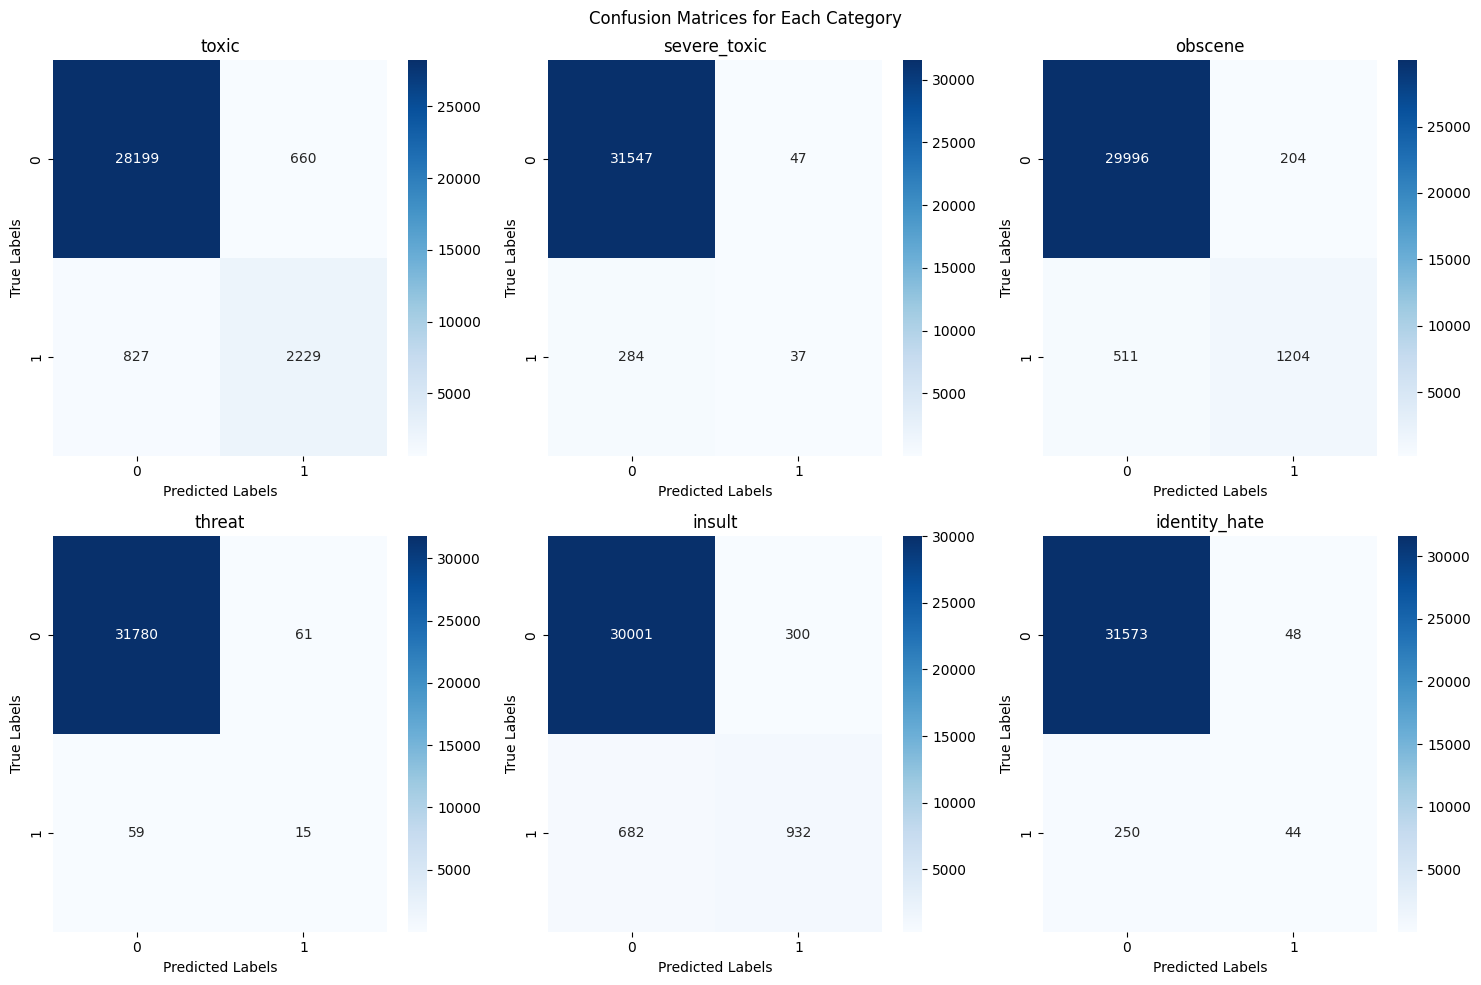

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels as numpy arrays
y_true = np.array(y_test)
y_pred = np.array(y_pred)

# Compute the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)

# Plotting each confusion matrix
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the layout based on your preference
fig.suptitle('Confusion Matrices for Each Category')

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i, cm in enumerate(confusion_matrices):
    ax = axes.flatten()[i]
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(label_names[i])
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Text Classification with the Trained Model

In this final section, we will use our trained model to classify new input text. This involves several key steps:



1.   Pre-processing the input
2.   Transforming text to features
3. Combining Features with Naive Bayes Probabilities
4. Model Prediction
5. Interpretation of the output



In [18]:
def classify_sentence(txt):
    # pre-processing the input
    txt = pre_process_comments([txt])

    # transforming text to features
    txt_bow = vectorizer.transform(txt)

    # generating naive bayes feature
    txt_nb_features = nb_classifier.predict_proba(txt_bow)

    # converting to 2D array
    txt_nb_features_2d = np.hstack(txt_nb_features)

    # converting to sparse matrix
    txt_nb_features_sparse = sparse.csr_matrix(txt_nb_features_2d)

    # combining BoW and Naive Bayes features
    txt_features = sparse.hstack([txt_bow, txt_nb_features_sparse])

    # making prediction
    pred_labels = sgd_clf.predict(txt_features)

    # replacing binary with labels
    labels =["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    txt_pred = [label for label, pred in zip(labels, pred_labels[0]) if pred == 1]

    # returning prediction
    return txt_pred


In [19]:
input_txt = "Fat man go eat with your nigga brother"
predicted_labels = classify_sentence(input_txt)

print(f"Predicted labels: {predicted_labels}")

Predicted labels: ['toxic', 'insult', 'identity_hate']


In [20]:
input_txt = "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
predicted_labels = classify_sentence(input_txt)

print(f"Predicted labels: {predicted_labels}")

Predicted labels: ['toxic', 'obscene', 'insult']


In [21]:
input_txt = "You're a gay"
predicted_labels = classify_sentence(input_txt)

print(f"Predicted labels: {predicted_labels}")

Predicted labels: ['toxic']
